# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
from DYNASMART_Process import *
import DYNASMART_Process as dy
import AV_functions as av
from gurobipy import *
import datetime
import requests

In [4]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
#Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
                                    ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
                                    inplace=True)
traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)

num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

In [6]:
for i in traveler_trips.tripmode.unique():
    print(i,len(traveler_trips.loc[traveler_trips.tripmode==i]))

1 173121
3 75304
7 63218
5 52429
10 4039
8 5908
14 5384
13 2037
11 314
12 404


### Basic Statistics

In [9]:
traveler_trips.head()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,starttimeinterval,starttime,hh_id,origin_node,destination_node,Diff_bet_starttime,travel_time,person_type,earlyarr_penalty,latearr_penalty
0,8600957,11,0.1164,1,24.0,1,Home,Shop,1,1,...,1,1.0,2744264,9737,10716,30.0,6.0,Part-time-worker,0.01,0.01
1,8600957,11,0.1164,2,32.0,3,Shop,EatingOut,62,16,...,1,31.0,2744264,10716,10057,37.0,5.0,Part-time-worker,0.01,0.01
2,8600957,11,0.1164,3,39.0,1,eatingout,Maintenance,20,5,...,1,68.0,2744264,10021,9674,41.0,2.0,Part-time-worker,0.01,0.01
3,8600957,11,0.1164,4,198.0,3,Maintenance,Home,3,1,...,1,109.0,2744264,9737,9675,199.0,1.0,Part-time-worker,0.00,0.02
4,8600957,11,0.1164,5,191.0,1,Home,Work,1,1,...,8,308.0,2744264,9673,9736,192.0,1.0,Part-time-worker,0.20,0.50


In [10]:
traveler_trips.columns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time', 'person_type', 'earlyarr_penalty', 'latearr_penalty'],
      dtype='object')

In [11]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

Number of household: 	 32472
Number of traveler: 	 76499
Number of trips: 	 382158
Number of indiv trip: 	 333264
Number of joint trip: 	 48894


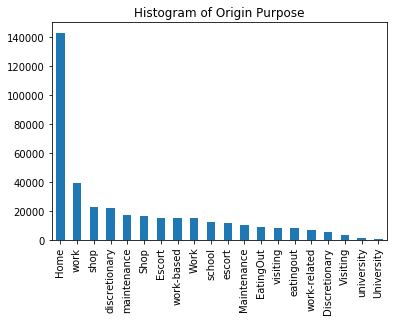

In [12]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

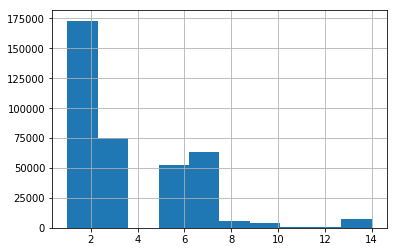

In [13]:
traveler_trips.tripmode.hist()

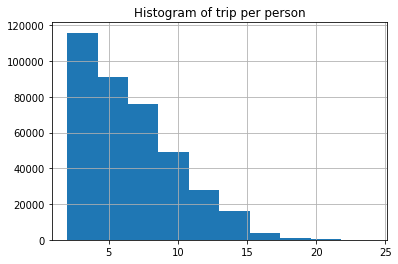

In [14]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

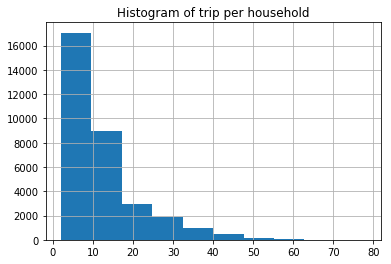

In [15]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

In [16]:
def identify_indiv_trip_before_jointtrip(traveler_trips):
    before_joint_trip=pd.DataFrame()
    for traveler in traveler_trips.person_id.unique():
#         print(traveler,len(traveler_trips[traveler_trips.person_id==traveler])-1)
        for index in range(len(traveler_trips[traveler_trips.person_id==traveler])-1):
#             if(traveler==5982639):
#                 print(traveler,index,(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0),(traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1)) 
            if (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index]['joint_trip_flag']==0) & (traveler_trips.loc[traveler_trips.person_id==traveler].iloc[index+1]['joint_trip_flag']==1):  
#                 print(traveler,index)
                before_joint_trip=before_joint_trip.append(traveler_trips[traveler_trips.person_id==traveler].iloc[index])
    check_joint_trip=traveler_trips.loc[(traveler_trips['joint_trip_flag']==1) & (traveler_trips.trip_counter>2)]
    
#     if (len(check_joint_trip)/2 != len(before_joint_trip)):
#         print(traveler_trips.hh_id.unique(),len(check_joint_trip)/2, len(before_joint_trip))
    return before_joint_trip

In [17]:
# num_ind_trip=[]
# for hh in traveler_trips.hh_id.unique():
#     target_hh=traveler_trips[traveler_trips.hh_id==hh]
#     num_ind_trip.extend([len(identify_indiv_trip_before_jointtrip(target_hh))])

### Draw the sub-area network

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hol

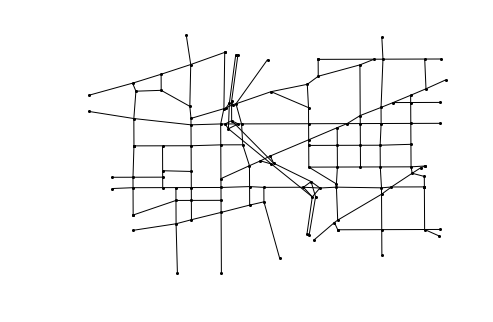

In [18]:
cluster_highlight([])

### Sample Household
Select household 2105189 for intial analysis

10


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hol

9
4
7


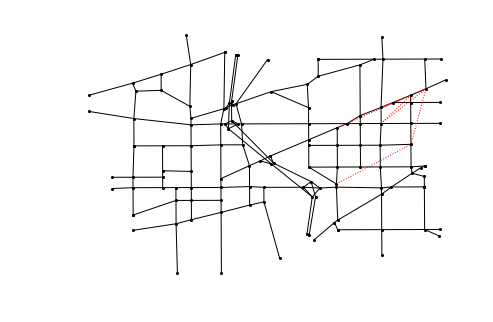

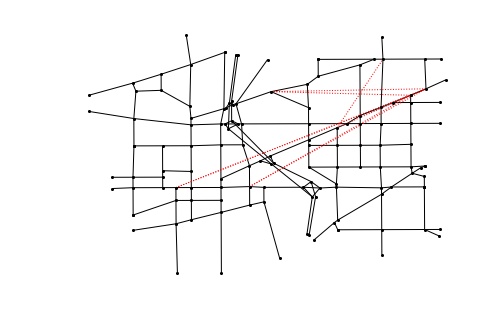

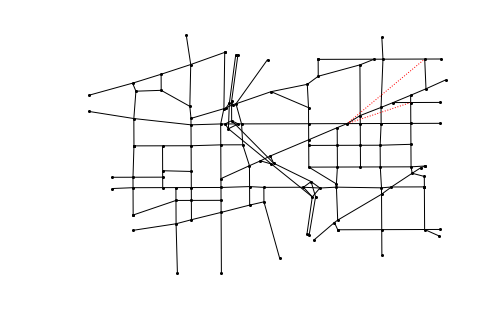

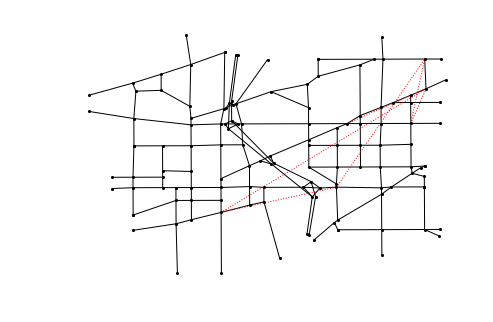

In [19]:
target_hh_id=2105189
people_in_hh=traveler_trips[traveler_trips['hh_id']==2105189]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

In [20]:
target_hh=traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

In [21]:
# target_hh_id=2105189
# hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
# # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
# num_hh_member=hh_members.size

# target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
# sorted_trips=target_hh.sort_values("starttime")
# hh_num_trips=sorted_trips.shape[0]
# sorted_trips["hh_index"]=(range(hh_num_trips))
# R=np.ones(hh_num_trips+1)*15
# #Calculate the distance matrix between all node pairs
# np.random.seed(1)
# C=np.random.rand(2*hh_num_trips+2,2*hh_num_trips+2)*10
# visit_candidate=[sorted_trips['origin_node'].iloc[0]]
# visit_candidate.extend(sorted_trips['origin_node'].tolist())
# visit_candidate.extend(sorted_trips['destination_node'].tolist())
# visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
# # C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)
# c=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)

#### Solve with heuristic

In [22]:
# #Solve with heuristic
# ############################
# #Construct initial feasible solution
# def initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate):
#     #First start with the earlist trip and add the next trip whenever possible
#     #########################
#     #Sort all household trips by time
#     trip_list=[]
#     last_start_time=0
#     last_dest_index=0
#     last_travel_time=0 #The travel time between the OD of same trip
#     trip_list=[]
#     index=0
#     for index1,trip in sorted_trips.iterrows():
#         #If it does not violate the time constraint then add the trip to the route
#         current_travel_time=C[last_dest_index,index+1] #The travel time between the orig of #current trip and the dest of last trip
#         print(trip['starttime'],'\t',index+1,'\t',last_dest_index,'\t',last_travel_time,'\t',last_start_time,'\t',current_travel_time)
#         if trip['starttime']>last_travel_time+last_start_time+current_travel_time:
#             trip_list.extend([trip['hh_index']])
#             last_start_time=trip['starttime']
#             last_dest_index=index+1+hh_num_trips
#             last_travel_time=C[index+1,index+1+hh_num_trips]
#             print(last_dest_index,index+1,trip['hh_index'])
#         index+=1
#     return trip_list

In [23]:
# i=0
# num_optimization=0
# num_conflict_trips={}
# last_time=datetime.datetime.now()
# for target_hh_id in [2105189]: #traveler_trips['hh_id'].unique():
# #     hh_members=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
#     # hh_num_trips=traveler_trips[traveler_trips['hh_id']==target_hh_id]['num_trips'].value_counts().sum()
#     num_hh_member=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique().size
#     target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
#     sorted_trips=target_hh.sort_values("starttime")
#     hh_num_trips=sorted_trips.shape[0]
#     sorted_trips["hh_index"]=(range(hh_num_trips))
#     C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
#     visit_candidate=[sorted_trips['origin_node'].iloc[0]]
#     visit_candidate.extend(sorted_trips['origin_node'].tolist())
#     visit_candidate.extend(sorted_trips['destination_node'].tolist())
#     visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])
#     C= av.calculate_node_distance_matrix(visit_candidate,nodexy,C)*1.5*5
# #     C=av.calculate_node_travel_time_matrix(visit_candidate,nodexy)
#     route=initial_solution(sorted_trips,hh_num_trips,num_hh_member,C,visit_candidate)
#     i=i+1
#     if len(route)!=hh_num_trips:
#         num_optimization=num_optimization+1
#         if (hh_num_trips-len(route)) in num_conflict_trips:
#             num_conflict_trips[hh_num_trips-len(route)]=num_conflict_trips[hh_num_trips-len(route)]+1
#         else:
#             num_conflict_trips[hh_num_trips-len(route)]=1
#     if (i%1000==0):
#         print(i,target_hh_id,num_optimization,datetime.datetime.now()-last_time)
# #         last_time=datetime.datetime.now()

## Estimate travel time and cost

### Estimate vehicular travel time and cost from skim file (result from previous run)

In [24]:
def read_vehicle_skim(skim_folder_path):
    '''
    This function reads in the skim file information and store them in a multiindex dataframe Vehicular_Skim
    '''
    Max_Num_Vot=5
    # Get the basic parameters for reading the vehicle skim
    NumSkimSuperZone=len(os.listdir(skim_folder_path))
    with open(skim_folder_path+'/1.dat') as f: 
        for line,i in zip(f,range(3)):
            if i==0 and 'TAZ' in line: 
                NumIteration=1
                NumSkimOriginZone=line.split()[0]
            elif i==0 and 'NTI' in line: 
                NumIteration=0
                NumSkimIntervals=line.split()[0]
            elif i==1 and 'NTI' in line: 
                NumSkimIntervals=line.split()[0]
            elif i==1 and 'TAZ' in line:
                NumSkimOriginZone=line.split()[0]
    NumSkimIntervals=int(NumSkimIntervals)
    NumSkimOriginZone=int(NumSkimOriginZone)
    print(NumSkimSuperZone,NumSkimOriginZone,NumSkimIntervals)
    #Create a list of Time and Origin. The list is determined by how the data were writen in the vehicularpnrskim
    #When interation equals 0, the file iterate through time frist. In other words the loop should be writen as 
    #(do O=1,NumSkimOriginZone: do T=1, NumSkimIntervals). When iteration number is lager than 1, the order reverse
    if NumIteration>0:
        Tlist=list(range(1,NumSkimIntervals+1))*NumSkimOriginZone
        Olist=list(np.repeat(range(1,NumSkimOriginZone+1),NumSkimIntervals))
    else:
        Tlist=list(np.repeat(range(1,NumSkimIntervals+1),NumSkimOriginZone))
        Olist=list(range(1,NumSkimOriginZone+1))*NumSkimIntervals
    #Start to read the files 
    Os=[]
    Ds=[]
    Ts=[]
    VotNo=[]
    VotValue=[]
    Cost=[]
    Time=[]
    Dist=[]
    for D in range(1,NumSkimSuperZone+1): #D is the destination 
        print('read',D,datetime.datetime.now())
        with open(skim_folder_path+'/'+str(D)+'.dat') as f: 
            for _ in range(2):
                next(f)
            for line,O,T in zip(f,Olist,Tlist): 
                line_list=line.split()
                Num_VOT=int(line_list[0])
                for j in range(1,Num_VOT+1): 
                    Os.extend([int(O)])
                    Ds.extend([int(D)])
                    Ts.extend([int(T)])
                    VotNo.extend([j])
                    VotValue.extend([float(line_list[4*j-3])])
                    Cost.extend([float(line_list[4*j-2])])
                    Time.extend([float(line_list[4*j-1])])
                    Dist.extend([float(line_list[4*j])])
    Vehicular_Skim=pd.DataFrame(data={'O':Os,'D':Ds,'T':Ts,'VotIndex':VotNo,'Vot':VotValue
                                     ,'Cost':Cost,'Time':Time,'Dist':Dist})          
    Vehicular_Skim.set_index(['O', 'D','T','VotIndex'], inplace=True)
    Vehicular_Skim.sort_index(inplace=True)
    return Vehicular_Skim

In [25]:
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim=read_vehicle_skim(VPNRSkim_folder_filepath)

56 57 144
read 1 2018-02-21 16:10:29.179256
read 2 2018-02-21 16:10:29.250259
read 3 2018-02-21 16:10:29.330269
read 4 2018-02-21 16:10:29.423268
read 5 2018-02-21 16:10:29.511274
read 6 2018-02-21 16:10:29.613286
read 7 2018-02-21 16:10:29.710285
read 8 2018-02-21 16:10:29.812290
read 9 2018-02-21 16:10:29.892298
read 10 2018-02-21 16:10:30.007304
read 11 2018-02-21 16:10:30.113308
read 12 2018-02-21 16:10:30.201312
read 13 2018-02-21 16:10:30.324324
read 14 2018-02-21 16:10:30.446326
read 15 2018-02-21 16:10:30.542331
read 16 2018-02-21 16:10:30.618341
read 17 2018-02-21 16:10:30.692340
read 18 2018-02-21 16:10:30.790347
read 19 2018-02-21 16:10:30.860349
read 20 2018-02-21 16:10:30.960355
read 21 2018-02-21 16:10:31.046365
read 22 2018-02-21 16:10:31.132364
read 23 2018-02-21 16:10:31.241371
read 24 2018-02-21 16:10:31.347376
read 25 2018-02-21 16:10:31.471383
read 26 2018-02-21 16:10:31.544386
read 27 2018-02-21 16:10:31.620397
read 28 2018-02-21 16:10:31.711402
read 29 2018-02-21 

In [26]:
def read_transit_setting(transit_setting_filepath):
    f=open(transit_setting_filepath,'r')
    TransitMazTazFlag=int(next(f).split()[0])
    drivingweight=float(next(f).split()[0])
    walkingweight=float(next(f).split()[0])
    TransitSkimTimeIntervalLength=float(next(f).split()[0])
    MaxNumTransitSkimTimeInterval=int(int(next(f).split()[0]))
    WalkSpeed=float(next(f).split()[0])
    return TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed
def read_pnr_zones(three_link_pnr):
    '''
    This function is called by function read_transitskim
    This function return the transit_zone_candidates where the first column is the zones in the 
    DYNSMART network and the second column is the transit zone in the three-link zone, which is
    indicated by the first column
    '''
    from collections import defaultdict
    transit_zone_candidates=defaultdict(list)
    for line in three_link_pnr:
        if 'tran' not in line:
            transit_zone_candidates[int(line.split()[0])].extend([int(line.split()[1])])
    return transit_zone_candidates
def read_threelink_walk(three_link_walk_file):
    three_link_walk_list=[]
    for line in three_link_walk_file:
        if 'tran' not in line: 
            three_link_walk_list.append([float(i) for i in line.split()])
    
    three_link_walk=pd.DataFrame(data=three_link_walk_list,columns=['three_link_zone','transit_zone','distance'])
    return three_link_walk
def read_transitskim(transit_skim_folderpath):
    '''
    This function call the read_transit_setting function and read_pnr_zones function
    This function returns all the NUTRANS realated parameters such as:TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed
    This function returns the transit zone associated with each DYNSAMART zone in transit_zone_candidates
    This function also returns the transit AB cost skim which is the estimated travel time between zones at each time interval
    
    '''
    #First read the transit setting file
    transit_setting_filepath=transit_skim_folderpath+'TransitSetting.dat'
    TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed=read_transit_setting(transit_setting_filepath)
    #Next depends on the setting file determine whether the file is maz based or taz based
    ab_time_f=open(transit_skim_folderpath+'TransitPNRSkim_AB_time.dat','r')
    if TransitMazTazFlag==0:
        ab_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_AB_cost.dat','r')
        ba_time_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_time.dat','r')
        ba_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_cost.dat','r')
        three_link_pnr=open(transit_skim_folderpath+'input_threelink_PNR.dat','r')
        three_link_walk_file=open(transit_skim_folderpath+'input_threelink_walk.dat','r')
    else:
        ab_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_AB_cost_TAZ.dat','r')
        ba_time_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_time_TAZ.dat','r')
        ba_cost_f=open(transit_skim_folderpath+'TransitPNRSkim_BA_cost_TAZ.dat','r')
        three_link_pnr=open(transit_skim_folderpath+'input_threelink_PNR_TAZ.dat','r')
        three_link_walk_file=open(transit_skim_folderpath+'input_threelink_walk_TAZ.dat','r')
    transit_zone_candidates=read_pnr_zones(three_link_pnr)
    three_link_walk=read_threelink_walk(three_link_walk_file)
    cost_temp=[]
    for line in ab_cost_f:
        cost_temp.append([float(i) for i in line.split()])
    time_temp=[]
    for line in ab_time_f:
        time_temp.append([float(i) for i in line.split()])
    column_name=['otap','dtap']
    column_name.extend([i for i in range(MaxNumTransitSkimTimeInterval)])
    Transit_AB_Cost_Skim=pd.DataFrame(data=cost_temp,columns=column_name)
    Transit_AB_Time_Skim=pd.DataFrame(data=time_temp,columns=column_name)
    return TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk

In [27]:
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=read_transitskim(transit_skim_folderpath)

In [28]:
Transit_AB_Cost_Skim.head()

,otap,dtap,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,24.0,1440.0,1440.0,1440.0,1440.0,34.0,34.0,19.5,19.5,...,1440.0,1440.0,1440.0,1440.0,1440.0,35.0,1440.0,1440.0,1440.0,1440.0
2,4.0,34.0,1440.0,1440.0,1440.0,1440.0,34.0,34.0,19.5,19.5,...,1440.0,1440.0,1440.0,1440.0,1440.0,35.0,1440.0,1440.0,1440.0,1440.0
3,4.0,36.0,1440.0,1440.0,1440.0,1440.0,109.7,82.4,83.4,110.7,...,1440.0,1440.0,1440.0,1440.0,1440.0,111.7,1440.0,1440.0,1440.0,1440.0
4,4.0,37.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,...,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0


In [29]:
three_link_walk.head()

,three_link_zone,transit_zone,distance
0,1.0,4.0,4702.091222
1,1.0,24.0,18806.588630
2,1.0,37.0,18982.033670
3,1.0,65.0,21330.843820
4,1.0,39.0,21422.376550


### Derive travel time from Google api

In [30]:
# #Derive the travel time matrix from google api
# origin_node=[]
# destination_node=[]
# travel_time=[]
# k=0
# for i in nodexy:
#     print(k)
#     k=k+1
#     for j in nodexy:
#         origin_node.extend([i])
#         destination_node.extend([j])
#         travel_time.extend([travel_time_between_nodes(int(i),int(j),nodexy)])

## Solve the optimization with Gurobi

In [49]:
def get_travel_cost_matrix(sorted_trips,Vehicular_Skim,superzone_map):
    '''
    This function returns two matrix: 
    C: the cost matrix
    TT: the travel time matrix
    '''
    
    num_skim_interval=Vehicular_Skim.index.get_level_values('T').max()
    
    hh_num_trips=sorted_trips.shape[0]
    C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    TT=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    visit_candidate_zone=[sorted_trips['orig_taz'].iloc[0]]
    visit_candidate_zone.extend(sorted_trips['orig_taz'].tolist())
    visit_candidate_zone.extend(sorted_trips['dest_taz'].tolist())
    visit_candidate_zone.extend([sorted_trips['orig_taz'].iloc[0]])
#     midday_timeinterval=len(Vehicular_Skim.index.get_level_values('T').unique())*5/24

    correlated_skim_time_interval=[math.ceil(sorted_trips.starttime.iloc[0].item()/num_skim_interval)]
    correlated_skim_time_interval.extend(sorted_trips.starttime.apply(lambda x: math.ceil(x/num_skim_interval)))
    correlated_skim_time_interval.extend(sorted_trips.starttime.apply(lambda x: math.ceil(x/num_skim_interval)))
    correlated_skim_time_interval.extend([math.ceil(sorted_trips.starttime.iloc[-1].item()/num_skim_interval)])
    correlated_vot=[0.16]
    correlated_vot.extend(sorted_trips.value_of_time)
    correlated_vot.extend([0.16]*(hh_num_trips+1))
    for i,ozone in zip(range(len(visit_candidate_zone)),visit_candidate_zone):
        for j,dzone in zip(range(len(visit_candidate_zone)),visit_candidate_zone):
            if i!=j:
                time_temp=Vehicular_Skim.loc[ozone,superzone_map[dzone],correlated_skim_time_interval[i],1]['Time'].item()
                cost_temp=Vehicular_Skim.loc[ozone,superzone_map[dzone],correlated_skim_time_interval[i],1]['Cost'].item()
                C[i,j]=time_temp*correlated_vot[i]+cost_temp
                TT[i,j]=time_temp
#                 C[i,j]=Vehicular_Skim.loc[ozone,superzone_map[dzone],72,1]['Time'].item()
            else:   
                C[i,j]=0
                TT[i,j]=0
#             if i>0 and j ==i+hh_num_trips:
#                 print(sorted_trips['travel_time'].iloc[i-1])
#                 print('check')
#                 print(Vehicular_Skim.loc[ozone,dzone,72,1]['Time'])
    for i in range(hh_num_trips): 
        C[i+1,i+hh_num_trips+1]=sorted_trips['travel_time'].iloc[i]
    return C,TT

In [32]:
def estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk):
    if TransitMazTazFlag==0:
        orig_column_name='orig_maz'
        dest_column_name='dest_maz'
    else: 
        orig_column_name='orig_taz'
        dest_column_name='dest_taz'
    R=[150]
    for index,row in sorted_trips.iterrows():
        min_transit_time=1440
        transit_time_temp=1440
        transit_start_time_interval=math.ceil(row.starttime/TransitSkimTimeIntervalLength)-1
        for otap in three_link_walk.loc[three_link_walk.three_link_zone==row[orig_column_name]].transit_zone:
            for dtap in three_link_walk.loc[three_link_walk.three_link_zone==row[dest_column_name]].transit_zone:
                if Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) & 
                                            (Transit_AB_Cost_Skim.dtap==dtap)].empty:
                    transit_time_temp=1440
                else:
                    transit_time_temp=Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) 
                                                               &(Transit_AB_Cost_Skim.dtap==dtap)
                                                              ,int(transit_start_time_interval)].item()
                    if transit_time_temp==0:
                        transit_time_temp=1440
                if (transit_time_temp<min_transit_time):
                    min_transit_time=transit_time_temp
                    otap_candidate=otap
                    dtap_candidate=dtap
        R.extend([min_transit_time])
    return R


In [33]:
def estimate_single_transit_trip_cost(origin_zone,dest_zone,trip_start_time,TransitMazTazFlag,three_link_walk,Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength):
    min_transit_time=1440
    transit_time_temp=1440
    transit_start_time_interval=math.ceil(trip_start_time/TransitSkimTimeIntervalLength)-1
    for otap in three_link_walk.loc[three_link_walk.three_link_zone==origin_zone].transit_zone:
        for dtap in three_link_walk.loc[three_link_walk.three_link_zone==dest_zone].transit_zone:
            if Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) & 
                                        (Transit_AB_Cost_Skim.dtap==dtap)].empty:
                transit_time_temp=1440
            else:
                transit_time_temp=Transit_AB_Cost_Skim.loc[(Transit_AB_Cost_Skim.otap==otap) 
                                                           &(Transit_AB_Cost_Skim.dtap==dtap)
                                                          ,int(transit_start_time_interval)].item()
                if transit_time_temp==0:
                    transit_time_temp=1440
            if (transit_time_temp<min_transit_time):
                min_transit_time=transit_time_temp
                otap_candidate=otap
                dtap_candidate=dtap
    return min_transit_time

In [34]:
def estimate_single_car_trip_cost(origin_zone,dest_zone,trip_start_time,vot,Vehicular_Skim):
    num_skim_interval=Vehicular_Skim.index.get_level_values('T').max()
    correlated_skim_time_interval=math.ceil(trip_start_time/num_skim_interval)
    time_temp=Vehicular_Skim.loc[origin_zone,superzone_map[dest_zone],correlated_skim_time_interval,1]['Time'].item()
    cost_temp=Vehicular_Skim.loc[origin_zone,superzone_map[dest_zone],correlated_skim_time_interval,1]['Cost'].item()
    car_trip_cost=time_temp*vot+cost_temp
    return car_trip_cost

In [36]:
# origin_trips_test=traveler_trips[traveler_trips.hh_id.isin(route_infos_full_adoption.hh_id.unique())].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
# mode_list=[]
# for index,row in origin_trips_test.iterrows():
#     transit_cost=estimate_single_transit_trip_cost(row.orig_maz,row.dest_maz,row.starttime,TransitMazTazFlag,three_link_walk,Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
#     car_cost=estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim)
#     print(transit_cost)
#     if transit_cost>car_cost:
#         mode_list.extend([0])
#     else:
#         mode_list.extend([1])

In [149]:
def extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map):
    '''
    Get the household related information. Those information will be used as input
    for the optimization model
    '''
    num_hh_member=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique().size
    target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
    #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
    sorted_trips=target_hh.sort_values("starttime")
    hh_num_trips=sorted_trips.shape[0]
    #hh_index give an index to all trips within the household for tracking purpose
    sorted_trips["hh_index"]=(range(hh_num_trips))
    
    #Then only keep the 
#     sorted_trips=sorted_trips.drop_duplicates(['orig_purpose','dest_purpose','orig_maz','dest_maz','starttime'],keep='first')
    C=np.ones((2*hh_num_trips+2,2*hh_num_trips+2))
    visit_candidate=[sorted_trips['origin_node'].iloc[0]]
    visit_candidate.extend(sorted_trips['origin_node'].tolist())
    visit_candidate.extend(sorted_trips['destination_node'].tolist())
    visit_candidate.extend([sorted_trips['origin_node'].iloc[0]])

    C,TT=get_travel_cost_matrix(sorted_trips,Vehicular_Skim,superzone_map)
    visit_candidate_zone=[sorted_trips['orig_taz'].iloc[0]]
    visit_candidate_zone.extend(sorted_trips['orig_taz'].tolist())
    visit_candidate_zone.extend(sorted_trips['dest_taz'].tolist())
    visit_candidate_zone.extend([sorted_trips['orig_taz'].iloc[0]])
    
    expected_arrival_time=np.ones(2*hh_num_trips+2)
    expected_arrival_time[0]=traveler_trips[traveler_trips['hh_id']==target_hh_id]['starttime'].min()-1
    expected_arrival_time[1:hh_num_trips+1]=sorted_trips.starttime
    expected_leave_time=np.ones(2*hh_num_trips+2)
    expected_leave_time[0:hh_num_trips+1]=expected_arrival_time[0:hh_num_trips+1]
    early_penalty=100*np.ones(2*hh_num_trips+2)
    late_penalty=100*np.ones(2*hh_num_trips+2)
    early_penalty[1:hh_num_trips+1]=sorted_trips.earlyarr_penalty
    late_penalty[1:hh_num_trips+1]=sorted_trips.latearr_penalty
    early_penalty[hh_num_trips+1:2*hh_num_trips+1]=sorted_trips.earlyarr_penalty
    late_penalty[hh_num_trips+1:2*hh_num_trips+1]=sorted_trips.latearr_penalty
    for i in range(1+hh_num_trips,2*hh_num_trips+1):
        expected_arrival_time[i]=expected_arrival_time[i-hh_num_trips]+C[i-hh_num_trips,i]
        expected_leave_time[i]=expected_arrival_time[i-hh_num_trips+1]
        
        #         print(i,i-hh_num_trips,hh_num_trips,expected_arrival_time[i-hh_num_trips],expected_arrival_time[i],C[i-hh_num_trips,i])
    
    expected_arrival_time[2*hh_num_trips+1]=1440
    expected_leave_time[2*hh_num_trips+1]=1440
    expected_leave_time[2*hh_num_trips]=1440
    return num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone

def dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,R,output_flag):
    m1=Model("AVSchedule")
    x=m1.addVars(2*hh_num_trips+2,2*hh_num_trips+2,vtype=GRB.BINARY,name="x")
    T=m1.addVars(2*hh_num_trips+2,name="T") #T represent the expected arrivial time at a node
    S=m1.addVars(2*hh_num_trips+2,name="S")
#     R=np.ones(hh_num_trips+1)*150
    # B=traveler_trips[traveler_trips['hh_id']==household]['starttime'].max()-traveler_trips[traveler_trips['hh_id']==household]['starttime'].min()
    B=1440
    #Add constraints
    ###################################
    #Basic deliver and pickup constraints
    # m1.addConstrs((x[0,i]==1 for i in range(1,2)),"adf")
    m1.addConstrs((x.sum(i,'*')==1 for i in range(1)),"FromDepot2")
    m1.addConstrs((x.sum('*',i)==1 for i in [2*hh_num_trips+1]),"ToDepot3") 
    m1.addConstrs((x.sum(i,"*")==x.sum("*",i+hh_num_trips) for i in range(1,hh_num_trips+1)),"DemandbeDelivered11")
    m1.addConstrs((x.sum(i,"*")<=1 for i in range(2*hh_num_trips+1)),"PickupOnce12")
    m1.addConstrs((x.sum("*",j)<=1 for j in range(1,2*hh_num_trips+2)),"DeliverOnce13")
    m1.addConstrs((x.sum("*",i)==x.sum(i,"*") for i in range(1,2*hh_num_trips+1)),"FlowConvervative14")
    m1.addConstrs((x[i,i]==0 for i in range(2*hh_num_trips+2)),"NoSamePointCircleVisit")
    # ###################################
    #Time constratins
    # m1.addConstrs((T[i]==expected_arrival_time[i] for i in range(2*hh_num_trips+2)),'ExactStartTime')
    m1.addConstrs((T[j]-T[i]-B*x[i,j]>=TT[i,j]-B for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2)),"precedencet15")
    m1.addConstrs((T[i+hh_num_trips]-T[i]-B*x.sum(i,"*")>=(TT[i,i+hh_num_trips]-B) for i in range(1,hh_num_trips+1)),"deliverafterpickup16")

    # ####################################
    # #Late/Early Arrival penalty
    m1.addConstrs((S[i]>=early_penalty[i]*(expected_arrival_time[i]-T[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')
    m1.addConstrs((S[i]>=late_penalty[i]*(T[i]-expected_arrival_time[i]) for i in range(1,2*hh_num_trips+2)),'earlyarrivalpenalty')
    # ####################################
    # Special Constraints for this problem
#     m1.addConstrs(x[i,j]==0 for i in range(1,hh_num_trips+1)
#                             for j in range(1,hh_num_trips+1)
#                             if sorted_trips.iloc[i-1]['person_id']==sorted_trips.iloc[j-1]['person_id']) #
    m1.addConstrs(T[i+hh_num_trips]<=T[j] for i in range(1,hh_num_trips+1)
                        for j in range(i+1,hh_num_trips+1)
                        if sorted_trips.iloc[i-1]['person_id']==sorted_trips.iloc[j-1]['person_id']
                 ) # For the same person, the sequence of activity can not be violated
    
    m1.addConstrs(x[i,j]==0 for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2) 
                  if expected_arrival_time[j]-expected_arrival_time[i]<-30) #
    obj1=sum(x.sum(i,'*')*R[i] for i in range(hh_num_trips+1))
    obj2=S.sum()
    obj3=sum(x[i,j]*C[i,j] for i in range(2*hh_num_trips+2) for j in range(2*hh_num_trips+2))
    m1.setObjective(obj1-obj2-obj3, GRB.MAXIMIZE)
    # m1.setObjective(obj1-obj3,GRB.MAXIMIZE)
    m1.setParam(GRB.Param.OutputFlag,output_flag)
    m1.Params.TIME_LIMIT=428
    m1.optimize()
    return m1,x,T
def break_route_to_seg(route_info,superzone_map):
    '''
    This function break the route of an av into segements for DYNASMART depends on the travelers. 
    The function is called by extract_route_from_model_solution
    '''
    
    seg_index=[0]
    seg_temp=0
    i=1
    intrasuperzone_flag=[0]*len(route_info)
    
    for index, row in route_info[1:].iterrows():    
        if(row.orig_zone==row.dest_zone or check_intrasuperzone(row.orig_zone,row.dest_zone,superzone_map)):
            seg_temp=seg_temp+1
        elif((row.person_id != route_info.iloc[i-1].person_id) 
           or (route_info.iloc[i-1].orig_zone==route_info.iloc[i-1].dest_zone)
            or (check_intrasuperzone(route_info.iloc[i-1].orig_zone,route_info.iloc[i-1].dest_zone,superzone_map))):
            seg_temp=seg_temp+1
        if(check_intrasuperzone(row.orig_zone,row.dest_zone,superzone_map) and row.orig_zone!=row.dest_zone ):
            intrasuperzone_flag[i]=1
        seg_index.extend([seg_temp])
        i=i+1
    route_info['seg_index']=seg_index
    route_info['intrasuperzone_flag']=intrasuperzone_flag
    route_info['veh_seg_index']=route_info[['hh_id','seg_index']].apply(lambda x: veh_seg_index_creator(x), axis=1)
    return route_info
def check_intrasuperzone(orig_taz,dest_taz,superzone_map):
    '''
    This fucntion check if the trip between orig_taz and dest_taz is within the same superzone
    '''
#     print(superzone_map.loc[superzone_map.Original_Zones==orig_taz]['SuperZone'].item,superzone_map.loc[superzone_map.Original_Zones==dest_taz]['SuperZone'][0])
    return superzone_map[orig_taz]==superzone_map[dest_taz]
    
def veh_seg_index_creator(x):
    return str(int(x[0]))+'_'+str(int(x[1]))

def extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time):
    #Check the feasibility of the answer
    #route_dic store the optimiztion model solution as a dictionary. The keys are the upstream node index and the answer is
    #the corresponding downstream node index
    hh_id=sorted_trips['hh_id'].iloc[0]
    potential_next_node=set(range(1,2*hh_num_trips+1))
    route_node=[0]
    travelers=[]
    vot=[]
    activity_time=[]
    start_time=[]
    origin_arrival_time=[]
    dest_arrival_time=[]
    orig_node=[]
    dest_node=[]
    while potential_next_node != set():
        for node in potential_next_node: 
            
            if x[route_node[-1],node].x>0.91:
                if (route_node[-1]==0): #Initialize the traveler list when it is the depot
                    traveler_set=set()
                    travelers.extend([0])
                    vot.extend([0.01])
                    activity_time.extend([0])
                elif (route_node[-1]<=hh_num_trips):
#                     print(traveler_set,sorted_trips.iloc[route_node[-1]-1]['person_id'])
                    traveler_set.add(sorted_trips.iloc[route_node[-1]-1]['person_id'])
                    travelers.extend([sorted_trips.iloc[route_node[-1]-1]['person_id']])
#                     print(route_node[-1],node,sorted_trips.iloc[route_node[-1]-1]['person_id'],traveler_set)
                else:
                    traveler_set.remove(sorted_trips.iloc[route_node[-1]-1-hh_num_trips]['person_id'])
                    if traveler_set ==set():
                        travelers.extend([0])
                        vot.extend([0.01])
                        activity_time.extend([0])
                    else:
                        travelers.extend([list(traveler_set)[0]])
#                     print(route_node[-1],node,sorted_trips.iloc[route_node[-1]-1-hh_num_trips]['person_id'],traveler_set)
#                 print(traveler_set,travelers)
    
                if traveler_set !=set():
        
                    vot.extend([sorted_trips[sorted_trips.person_id==travelers[-1]]['value_of_time'].iloc[0]])
                    activity_time.extend([max(0,expected_leave_time[node]-expected_arrival_time[node])])
#                     vot.extend([sorted_trips.iloc[route_node[-1]-1]['value_of_time']])
                start_time.extend([expected_leave_time[route_node[-1]]])
                origin_arrival_time.extend([T[route_node[-1]].x])
                dest_arrival_time.extend([T[node].x])
                orig_node.extend([sorted_trips])
                route_node.extend([node])
                break
        if route_node[-1] in potential_next_node:
            potential_next_node.remove(route_node[-1])
        else:
            potential_next_node=set()
            
    route=[visit_candidate_zone[x] for x in route_node]
    route_info=pd.DataFrame({'orig_zone':route[1:-1],'dest_zone':route[2:],'person_id':travelers[1:],
                             'orig_node_index':route_node[1:-1],'dest_node_index':route_node[2:],
                             'origin_arrival_time':origin_arrival_time[1:],'dest_arrival_time':dest_arrival_time[1:],
                             'value_of_time':vot[1:],'start_time':start_time[1:],'Activity_Time':activity_time[1:],
                             'hh_id':np.ones(len(route[1:-1]))*hh_id},
                            columns=['orig_zone','dest_zone','orig_node_index','dest_node_index',
                                     'person_id','origin_arrival_time','dest_arrival_time','value_of_time'
                                     ,'start_time','Activity_Time','hh_id'])
    # Drop the trip between a person's current destination and next trips's origin, as those are the same node
    route_info=route_info.loc[((route_info.orig_node_index-route_info.dest_node_index!=hh_num_trips-1)
                               | (route_info.orig_zone!=route_info.dest_zone)) ] 
    if not route_info.empty:
        route_info=break_route_to_seg(route_info,superzone_map)
    
    return route_info
def find_av_schedule_exact_method(target_hh_id,traveler_trips,Vehicular_Skim,superzone_map,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk,output_flag):
    num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
    R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)

    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,R,output_flag)
    route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    return route_info

def get_route_info_allhh(traveler_trips,output_flag):
    '''
    This function loops over all the household and find the optimal path for all of them. Return route_infos that 
    stores all the route related information for all households
    
    '''
    counter=0
    route_infos=pd.DataFrame()
    row_number=0
    for household_id in traveler_trips.hh_id.unique():
        print(household_id)
        row_number=row_number+len(traveler_trips[traveler_trips.hh_id==household_id])
        if counter%100==0: 
            print('Estimate Route for the ',counter,'th household ',datetime.datetime.now())
        counter=counter+1
        if len(traveler_trips[traveler_trips.hh_id==household_id])<30:
            route_info=find_av_schedule_exact_method(household_id,traveler_trips,Vehicular_Skim,superzone_map,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk,output_flag)
            if not route_info.empty:
                route_infos=route_infos.append(route_info)
    return  route_infos

In [38]:
def read_superzone_info(superzone_filepath):
    i=0
    origin_flag=0
    super_zone_flag=0
    origin_zone=[]
    superzone=[]
    with open(superzone_filepath) as f: 
        for line in f: 
            if i==2: 
                origin_flag=1
    
            if line.split()[0]=='Mapping':
                origin_flag=0
                super_zone_flag=1
            else:
                if origin_flag==1:
                    origin_zone.extend([int(j) for j in line.split()])
                elif super_zone_flag==1:
                    superzone.extend([int(j) for j in line.split()])
            i=i+1
    superzone_info=dict(zip(origin_zone,superzone))
    return superzone_info

In [39]:
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=read_superzone_info(superzone_filepath)

In [40]:
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)

In [41]:
def read_link_travel_time(link_travel_time_filepath):
    i=0
    with open(link_travel_time_filepath) as f:
        for line in f:
            i=i+1
            print(i,len(line),line,line==' ')
            if i ==6:
                z=line
    return z
def read_turn_penalty(turn_penalty_filepath):
    with open(turn_penalty_filepath) as f:
        for line in f:
            print(line)
    return 

##### Try to solve the problem for a single household

In [150]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=3474718
num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,R,output_flag)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())

prepare input for dial n ride model at  2018-02-22 11:15:23.202739
start sovling problem at  2018-02-22 11:15:38.046662
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 428.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 12070 rows, 7920 columns and 69132 nonzeros
Variable types: 176 continuous, 7744 integer (7744 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  Objective range  [5e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective -144911
Presolve removed 3873 rows and 3569 columns
Presolve time: 0.32s
Presolved: 8197 rows, 4351 columns, 32911 nonzeros
Variable types: 175 continuous, 4176 integer (4176 binary)

Root relaxation: objective 6.227153e+02, 2358 iterations, 0.44 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

H17657  7984                     487.6413300  557.14319  14.3%  10.5  181s
H17659  7621                     495.5444300  557.14319  12.4%  10.5  181s
 18795  8119  537.45969  124   27  495.54443  557.13138  12.4%  10.4  185s
 20710  8962  556.80786   34   71  495.54443  557.11784  12.4%  10.3  190s
 22742  9822  548.66269   69   78  495.54443  557.08809  12.4%  10.3  195s
*24112  9700             157     521.2504700  557.08399  6.87%  10.3  197s
*24117  9066             157     527.8123000  557.08399  5.55%  10.3  197s
 25004  9484  553.26087   80   72  527.81230  557.07449  5.54%  10.2  201s
*25097  9067             173     529.5573000  557.07449  5.20%  10.2  201s
 27315  9972  542.83417   98   67  529.55730  557.06400  5.19%  10.2  206s
 29584 10839  552.28089   98  160  529.55730  557.05286  5.19%  10.1  257s
 29586 10840  539.21981  123  128  529.55730  557.05286  5.19%  10.1  260s
 29590 10843  552.08268   62  139  529.55730  557.05286  5.19%  10.1  265s
 29594 10846  545.67986  

In [115]:
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)

In [77]:
sorted_trips

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,starttime,hh_id,origin_node,destination_node,Diff_bet_starttime,travel_time,person_type,earlyarr_penalty,latearr_penalty,hh_index
34409,10036942,8,0.0789,1,475.0,14,Home,School,80,20,...,155.0,3474718,10708,10710,479.0,4.0,Student-of-non-driving-age,0.20,0.50,0
37470,10036940,11,0.1184,1,319.0,10,Home,Work,80,20,...,159.0,3474718,10708,9863,379.0,60.0,Full-time-worker,0.20,0.50,1
91431,10036941,11,0.1184,1,73.0,10,Home,Discretionary,80,20,...,220.0,3474718,10646,10708,89.0,16.0,Full-time-worker,0.01,0.01,2
99681,10036939,15,0.1184,1,396.0,1,Home,Work,80,20,...,227.0,3474718,10708,10057,403.0,7.0,Full-time-worker,0.20,0.50,3
91432,10036941,11,0.1184,2,24.0,10,discretionary,Home,71,18,...,309.0,3474718,10711,10772,40.0,16.0,Full-time-worker,0.00,0.02,4
91433,10036941,11,0.1184,3,143.0,1,Home,Maintenance,80,20,...,349.0,3474718,10772,10709,148.0,5.0,Full-time-worker,0.01,0.01,5
314760,10036943,8,0.0789,1,316.0,7,Home,School,80,20,...,415.0,3474718,10708,10707,326.0,10.0,Student-of-non-driving-age,0.20,0.50,6
330471,10036937,6,0.1184,1,11.0,1,Home,Shop,80,20,...,456.0,3474718,10762,10597,18.0,7.0,Retired,0.01,0.01,7
330472,10036937,6,0.1184,2,118.0,1,Shop,Shop,54,14,...,474.0,3474718,10639,10597,122.0,4.0,Retired,0.01,0.01,8
91434,10036941,11,0.1184,4,65.0,1,maintenance,Home,71,18,...,497.0,3474718,10646,10707,66.0,1.0,Full-time-worker,0.00,0.02,9


In [116]:
route_info

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,value_of_time,start_time,Activity_Time,hh_id,seg_index,intrasuperzone_flag,veh_seg_index
0,20,20,1,2,10036942,154.100000,157.400000,0.0789,155.0,0.0,3474718.0,0,0,3474718_0
1,20,18,2,44,10036940,157.400000,159.000000,0.1184,159.0,0.0,3474718.0,1,0,3474718_1
2,18,20,44,3,10036940,159.000000,213.500000,0.1184,159.0,0.0,3474718.0,1,0,3474718_1
3,20,5,3,45,10036941,213.500000,219.000000,0.1184,220.0,1.0,3474718.0,2,0,3474718_2
4,5,20,45,4,10036941,219.000000,227.000000,0.1184,220.0,0.0,3474718.0,2,0,3474718_2
5,20,18,4,46,10036939,227.000000,229.600000,0.1184,227.0,0.0,3474718.0,3,0,3474718_3
6,18,5,46,47,10036939,229.600000,234.000000,0.1184,227.0,75.0,3474718.0,3,0,3474718_3
7,5,20,47,6,0,234.000000,349.000000,0.0100,309.0,0.0,3474718.0,4,0,3474718_4
8,20,18,6,49,10036941,349.000000,354.000000,0.1184,349.0,61.0,3474718.0,5,0,3474718_5
9,18,18,49,10,0,354.000000,372.912923,0.0100,415.0,0.0,3474718.0,6,0,3474718_6


In [168]:
temp=traveler_trips.loc[(traveler_trips.hh_id==3474718)].sort_values('starttime')
temp.to_csv('test1.csv')

In [152]:
len(sorted_trips)

43

In [182]:
z.loc[z.p_id==5,['orig_purpose','dest_purpose','starttime','tripmode']]

,orig_purpose,dest_purpose,starttime,tripmode
34409,Home,School,155.0,14
34410,school,Home,634.0,14
34411,Home,Shop,749.0,3
34412,shop,Home,855.0,3
34413,Home,Maintenance,960.0,5
34414,maintenance,Home,981.0,5
34415,Home,EatingOut,991.0,7
34416,eatingout,Home,1097.0,7


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


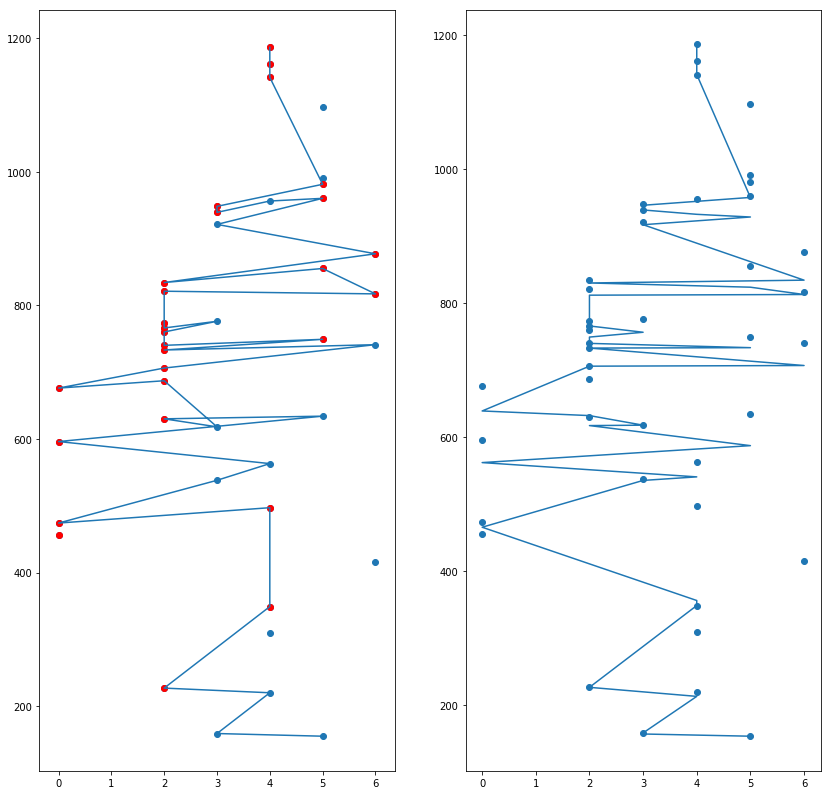

In [195]:
z=traveler_trips[traveler_trips.hh_id==3474718]

z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
plt.pyplot.figure(1,figsize=[14,14])
plt.pyplot.subplot(121)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time'])
# for i in z.p_id.unique():
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.subplot(122)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])

# plt.pyplot.scatter(z.p_id+0.5,z.expected_arrival)
# plt.pyplot.plot([0,0.5],[155,159])

In [ ]:
print('start sovling problem at ',datetime.datetime.now())
output_flag=0
target_hh_id=3578994
num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,visit_candidate_zone=extract_hh_information(target_hh_id,traveler_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
R=[150]*(hh_num_trips+1)
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,sorted_trips,expected_arrival_time,early_penalty,late_penalty,R,output_flag)
route_info1=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('finish solving problem at ',datetime.datetime.now())

In [ ]:
route_info

In [ ]:
route_info1

##### Solve the problem for all households

In [ ]:
route_infos=get_route_info_allhh(traveler_trips,0)

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

#### Write the route to DYNASMART input file vehicle.dat

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'

In [ ]:
def read_vehicledat(vehicledat_filepath):
    '''
    This function read all sort of vehicledat file. It returns a dataframe vehicle_info that 
    contains all the information. Each row is corresponding to one vehicle in the vehicle.dat. 
    
    '''
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum','NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    with open(vehicledat_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    dest_chain.append([])
                    activity_chain.append([])
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain[j-1].extend([taz_temp])
                    activity_chain[j-1].extend([activity_time])
                    
            i=i+1
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
    return vehicle_info
def read_pathdat(pathdat_filepath):
    path_bank=[]
    with open(pathdat_filepath) as f:
        for line in f:
            path_bank.append([int(i) for i in line.split()])
    return path_bank

In [ ]:
def read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath):
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum',
                  'NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    key=[]
    with open(intrasuperzone_vehicle_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain.extend([taz_temp])
                    activity_chain.extend([activity_time])
                    key.append(tuple([int(vehicle_info.iloc[j-1]['TAZMap']),int(taz_temp)]))
            i=i+1
        print(dest_chain)
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
        
    intrasuperzone_path=read_pathdat(intrasuperzone_path_filepath)
    intrasuperzone_info=vehicle_info
    intrasuperzone_info['path']=intrasuperzone_path
    intrasuperzone_path_dic=dict(zip(tuple(key),intrasuperzone_path))
    return intrasuperzone_info,intrasuperzone_path_dic

In [ ]:
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)

In [ ]:
Output_folder='Output/'
if not os.path.exists(Output_folder):
    os.makedirs(Output_folder)
vehicle_filepath=Output_folder+'vehicle_partconversion.dat'

In [ ]:
def route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time):
    '''
    This function write all the route information in the format of vehicle.dat
    '''
    vehicledat=open(vehicle_filepath,'w')
    pathdat=open(path_filepath,'w')
    if os.path.isfile(external_vehicle_filepath):
        external_vehicle=open(external_vehicle_filepath,'r')
        num_external_vehicle=int(next(external_vehicle).split()[0])
        next(external_vehicle)
        excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=next(external_vehicle).split()
        exTAZMap,exactivitytime=next(external_vehicle).split()
        exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
    else:
        exstime=1555
    
    num_veh_seg=len(route_infos['veh_seg_index'].unique())
    max_num_trip=route_infos.groupby('veh_seg_index')['start_time'].count().max()
    total_veh_seg=num_veh_seg+num_external_vehicle
    vehicledat.write(str(total_veh_seg)+'\t'+str(max_num_trip)+'\t'+'# of vehicles in the file, Max # of stops\n')
    vehicledat.write('counter  iutmp  idtmp  StartTime  ivcltmp  ivcl2tmp  ihovtmp  veh_pathnodenum  NonrepetitiveCarNumTrip  infotmp  ribftmp  comptmp  TAZMap  value_of_time  1\n')
    counter=1
    multiindex_route_infos=route_infos.set_index(['veh_seg_index'])
    for veh_seg in route_infos.sort_values('origin_arrival_time')['veh_seg_index'].unique():
        target_seg=multiindex_route_infos.loc[[veh_seg]]
        
        while target_seg.origin_arrival_time.min()>exstime:
            vehicledat.write(str(counter)+'\t'+exusec+'\t'+exdsec+'\t'+str(exstime)+'\t'+
                             exusrcls+'\t'+exvehtype+'\t'+exioc+'\t'+
                             '1'+'\t'+exintde+'\t'+exinfo+'\t'+exribf+'\t'+excomp+'\t'+
                             exoz+'\t'+str(average_value_of_time)+'\t'+'1'+'\n')
            vehicledat.write(exTAZMap+'\t'+exactivitytime+'\n')
            pathdat.write('\n')
            counter +=1
            line_listtemp=next(external_vehicle).split()
            if len(line_listtemp)>3:
                excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=line_listtemp
                exTAZMap,exactivitytime=next(external_vehicle).split()
                exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
            else: 
                exstime=1555
        if counter==23300:
            print(veh_seg,exstime,target_seg.start_time.min(),target_seg)
        write_one_veh_seq(target_seg,vehicledat,pathdat,counter,origin_links,superzone_map,intrasuperzone_path_dic)
        counter +=1
        if counter%1000==0: 
            print(counter,datetime.datetime.now())
    vehicledat.close()
    pathdat.close()
    return
def write_one_veh_seq(route_info,file_obj,path_file_obj,counter,origin_links,superzone_map,intrasuperzone_path_dic):
    '''
    This function convert the route information of one segment into vehicle.dat format. The function is called by route_to_vehiclepathdat
    '''
    ivcl2tmp=1        #Standard Input for Vehicle Specifications 
    ihovtmp=1         #Standard Input for Vehicle Specifications  
    veh_pathnodenum=1 #Standard Input for Vehicle Specifications
    ndestmp=1         #Standard Input for Vehicle Specifications
    infotmp=0         #Standard Input for Vehicle Specifications 
    ribftmp=0.0       #Standard Input for Vehicle Specifications  
    comptmp=0.0       #Standard Input for Vehicle Specifications  
    if (route_info.iloc[0].intrasuperzone_flag==1):
        path_temp=intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])]
        orig_u_node,orig_d_node=path_temp[0:2]
        ivcltmp=1
        veh_pathnodenum=len(path_temp)
        path_file_obj.write(''.join( str(j).rjust(7) for j in intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])])+'\n')
    else:
        target_zone=origin_links.loc[origin_links.zone_id==route_info.iloc[0]['orig_zone']]
        generateion_link_index=np.random.randint(0,len(target_zone))
        orig_u_node= target_zone.iloc[generateion_link_index]['u_node'] #Upstream node of the generation link 
        orig_d_node= target_zone.iloc[generateion_link_index]['d_node'] #Downstream node of the generation link
        ivcltmp=3
        veh_pathnodenum=1
        path_file_obj.write('\n')
    
    file_obj.write(str(counter)+'\t'+str(int(orig_u_node))+'\t'
                   +str(int(orig_d_node))+'\t'+str(round(route_info.iloc[0]['origin_arrival_time'],1))+'\t'
                   +str(ivcltmp)+'\t'+str(ivcl2tmp)+'\t'+str(ihovtmp)+'\t'+str(veh_pathnodenum)+'\t'
                   +str(len(route_info))+'\t'+str(infotmp)+'\t'+str(ribftmp)+'\t'
                   +str(comptmp)+'\t'+ str(route_info.iloc[0]['orig_zone'])+'\t'
                   +str(route_info.iloc[0]['value_of_time'])+'\t'+'1'+'\n')
    for (index,row) in route_info.iloc[:-1].iterrows():
        file_obj.write(str(row['dest_zone'])+'\t'+str(row['Activity_Time'])+'\n')
    file_obj.write(str(route_info['dest_zone'].iloc[-1])+'\t'+'0.0\n')
    if (route_info.dest_zone.iloc[-1]<1):
        print('error')
    return

In [ ]:
route_infos[route_infos.hh_id==869256]

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
# new_path='Output/newpath.dat'
# path_fileobj=open(new_path,'w')
# with open('Output/path.dat') as f:
#     for line in f: 
#         if len(line)>1:
#             for node in line.split():
#                 path_fileobj.write(node.rjust(7))
#             path_fileobj.write('\n')
#         else: 
#             path_fileobj.write('\n')
# path_fileobj.close()

#### Result Analysis